<a href="https://colab.research.google.com/github/herculeslyndel/msds-462/blob/master/FMNIST_Depp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies

#### General

In [1]:
import numpy as np
import sys
import os
import pathlib
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import pandas as pd


#### For models

In [2]:
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.optimizers import SGD
import tensorflow as tf
#from tf.keras import models
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix



Using TensorFlow backend.


### Settings

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12

In [5]:
pwd = !pwd
path = pwd[0]
this_file = 'fmnnist_for_dv1'

In [47]:
seed = 42

In [6]:
path

'/content'

### Utility functions

In [7]:
def stamp():
    import datetime, pytz
    t = datetime.datetime.now(pytz.timezone('US/Eastern'))
    return str(t.year)+str(t.month)+str(0)+str(t.day)+str(t.hour)+str(t.minute)

Visualize
  from Algae

In [8]:
def show(data, num_images): 
  rows = num_images // 4
  plt.figure(figsize=(5,5))
  for k in range(12):
      plt.subplot(rows, 4, k+1)
      plt.imshow(data[k], cmap='Greys')
      plt.axis('off')
  plt.tight_layout()
  plt.show()

Save visualizations

In [9]:
def save_fig(fig_id, tight_layout=True):
  print(f'Saving figure: {fig_id}')
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format='png', dpi=300)

Log files

In [10]:
from datetime import datetime
def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [12]:
# simpler version of this except it gets history from model and more
# https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object
import json, codecs
def saveModel(model, filename):
    new_hist = {}
    new_hist['history'] = {}
    new_hist['params'] = {}
    new_hist['config'] = {}
    for key in model.history.history.keys():
        new_hist['history'][key]=list(map(float, model.history.history[key]))
    for key in model.history.params.keys():
        new_hist['params'][key] = str(model.history.params[key])
    new_hist['config'] = json.loads(model.to_json())
    with codecs.open(filename, 'w', encoding='utf-8') as file:
        json.dump(new_hist, file, separators=(',', ':'), sort_keys=True, indent=4)

def loadModel(filename):
    with codecs.open(filename, 'r', encoding='utf-8') as file:
        n = json.loads(file.read())
    return n

### Working environment

#### Versions / devices

In [13]:
print(f'Operating system: {sys.platform}')
print(f'Python version: {sys.version}')
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')
print(f'Current working directory path: {os.getcwd()}')

device_name = tf.test.gpu_device_name()
if (device_name == ''):
    print('No GPU available')
else:
    print('Found GPU at: {}'.format(device_name))

Operating system: linux
Python version: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
TensorFlow version: 2.2.0
Keras version: 2.3.1
Current working directory path: /content
Found GPU at: /device:GPU:0


#### TPU MNIST training code snippit - unused

In [14]:
!python "/usr/share/models/official/mnist/mnist_tpu.py \
  --tpu=$TPU_NAME \
  --data_dir=${STORAGE_BUCKET}/data \
  --model_dir=${STORAGE_BUCKET}/output \
  --use_tpu=True \
  --iterations=500 \
  --train_steps=2000"

python3: can't open file '/usr/share/models/official/mnist/mnist_tpu.py   --tpu=   --data_dir=/data   --model_dir=/output   --use_tpu=True   --iterations=500   --train_steps=2000': [Errno 2] No such file or directory


#### Access Google drive / Kaggle

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls -l /content/gdrive/My\ Drive/
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp /content/gdrive/My\ Drive/credentials/kaggle.json ~/.kaggle/kaggle.json

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
total 2538
drwx------ 2 root root    4096 May  2 22:15  458
drwx------ 2 root root    4096 May  2 22:15  462
drwx------ 2 root root    4096 May  2 22:07  464
drwx------ 2 root root    4096 Apr  6 19:09 'Colab Notebooks'
-rw------- 1 root root     151 Jun 19 13:49 'Copy of Schools.gsheet'
drwx------ 2 root root    4096 May  2 22:28  credentials
drwx------ 2 root root    4096 May  2 22:15  data
drwx------ 2 root root    4096 May  3 12:08  dependencies
drwx-----

#### Load dataset

In [16]:
#https://www.kaggle.com/c/dogs-vs-cats

In [17]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp /content/gdrive/My\ Drive/credentials/kaggle.json ~/.kaggle/kaggle.json

In [18]:
!kaggle datasets download -d c/dogs-vs-cats

404 - Not Found


In [19]:
!kaggle datasets download -d zalando-research/fashionmnist
!ls -l /content
!unzip /content/fashionmnist.zip
!ls -la /content/

 83% 57.0M/68.8M [00:00<00:00, 49.6MB/s]
100% 68.8M/68.8M [00:00<00:00, 74.7MB/s]
total 70436
-rw-r--r-- 1 root root 72114846 Jun 27 05:06 fashionmnist.zip
drwx------ 4 root root     4096 Jun 27 05:06 gdrive
drwxr-xr-x 1 root root     4096 Jun 17 16:18 sample_data
Archive:  /content/fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  
total 275712
drwxr-xr-x 1 root root      4096 Jun 27 05:06 .
drwxr-xr-x 1 root root      4096 Jun 27 04:35 ..
drwxr-xr-x 1 root root      4096 Jun 25 17:02 .config
-rw-r--r-- 1 root root  22176691 Sep 21  2019 fashion-mnist_test.csv
-rw-r--r-- 1 root root 133047193 Sep 21  2019 fashion-mnist_train.csv
-rw-r--r-- 1 root root  72114846 Jun 27 05:06 fashionmnist.zip
drwx------ 4 root root      4096 Jun 27 05:06 gdrive
drwxr-xr-x 1 root root      4096 Jun 17 16:18 sam

In [20]:
path_train = "/content/fashion-mnist_train.csv"
path_test = "/content/fashion-mnist_test.csv"
data_train = pd.read_csv(path_train)
data_test = pd.read_csv(path_test)
train_array = np.array(data_train)
test_array = np.array(data_test)
data_train.info(), data_train.shape, data_test.info(), data_test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


(None, (60000, 785), None, (10000, 785))

#### isna or isnull ?

In [22]:
data_train.isnull().values.sum(), data_train.isna().values.sum(), data_test.isnull().values.sum(), data_test.isna().values.sum()

(0, 0, 0, 0)

In [23]:
labels = 'T-shirt/top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Ankle-boot'.split()
labels = dict(enumerate(labels))
labels_values = list(labels.values())
labels

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle-boot'}

In [24]:
labels_str_train = [labels[k] for k in [i for i in data_train.label]]
labels_str_test = [labels[k] for k in [i for i in data_test.label]]
data_train['label_str'] = labels_str_train
data_test['label_str'] = labels_str_test

In [25]:
print('Table: Mean correlations amongst images of items in train set')
pd.set_option('display.max_columns', None)  
(data_train.groupby('label_str').mean().T.corr()*100).astype(int)

Table: Mean correlations amongst images of items in train set


label_str,Ankle-boot,Bag,Coat,Dress,Pullover,Sandal,Shirt,Sneaker,T-shirt/top,Trouser
label_str,,,,,,,,,,
Ankle-boot,100,68,42,27,41,85,39,66,25,16
Bag,68,100,69,43,65,75,66,67,42,26
Coat,42,69,100,74,95,39,96,34,75,64
Dress,27,43,74,100,65,17,78,20,85,87
Pullover,41,65,95,65,100,38,94,31,72,56
Sandal,85,75,39,17,38,100,34,87,13,7
Shirt,39,66,96,78,94,34,100,29,86,65
Sneaker,66,67,34,20,31,87,29,100,12,13
T-shirt/top,25,42,75,85,72,13,86,12,100,73


#### Greyest white and black in train and test sets:


In [26]:
max([i.min() for i in train_array]), min([i.max() for i in train_array])

(0, 254)

In [27]:
max([i.min() for i in test_array]), min([i.max() for i in test_array])

(0, 254)

#### Mean pixel value for all samples, all labels, all pixels

In [28]:
train_array.mean(), test_array.mean()

(72.86962445859872, 73.07333898089172)

#### Mean value of each pixel in each letter in test

In [29]:
grey_train = round(data_train.groupby('label_str').mean().T.mean(),2)
grey_train 

label_str
Ankle-boot     76.92
Bag            89.93
Coat           98.04
Dress          66.12
Pullover       95.60
Sandal         34.83
Shirt          85.01
Sneaker        42.79
T-shirt/top    82.77
Trouser        56.68
dtype: float64

In [30]:
grey_test = round(data_test.groupby('label_str').mean().T.mean(),2)
grey_test 

label_str
Ankle-boot     75.43
Bag            90.28
Coat           99.49
Dress          65.52
Pullover       96.37
Sandal         35.31
Shirt          83.10
Sneaker        43.45
T-shirt/top    84.40
Trouser        57.39
dtype: float64

In [31]:
grey_diff = round(grey_train - grey_test,2)
grey_diff

label_str
Ankle-boot     1.49
Bag           -0.35
Coat          -1.45
Dress          0.60
Pullover      -0.77
Sandal        -0.48
Shirt          1.91
Sneaker       -0.66
T-shirt/top   -1.63
Trouser       -0.71
dtype: float64

In [32]:
print('Figure: Mean pixel values by item \nand between sets.')
pd.DataFrame({'Train':grey_train, 'Test': grey_test, 'Diff':grey_diff})

Figure: Mean pixel values by item 
and between sets.


,Train,Test,Diff
label_str,,,
Ankle-boot,76.92,75.43,1.49
Bag,89.93,90.28,-0.35
Coat,98.04,99.49,-1.45
Dress,66.12,65.52,0.60
Pullover,95.60,96.37,-0.77
Sandal,34.83,35.31,-0.48
Shirt,85.01,83.10,1.91
Sneaker,42.79,43.45,-0.66
T-shirt/top,82.77,84.40,-1.63


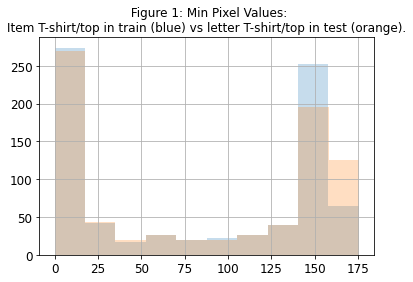

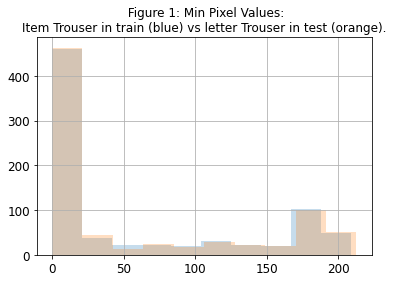

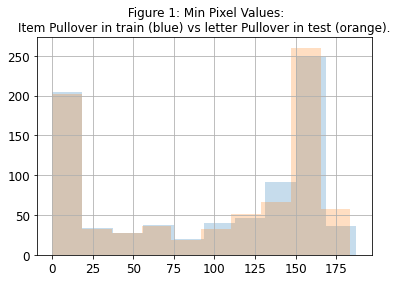

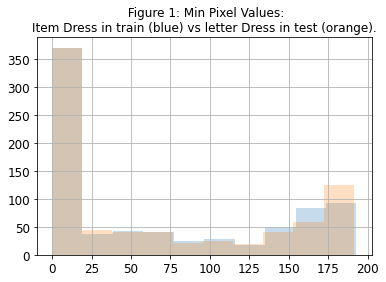

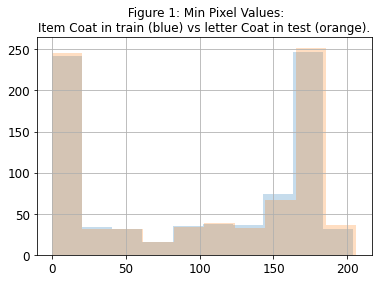

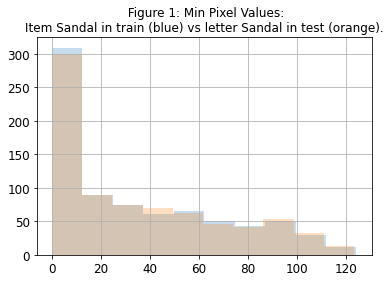

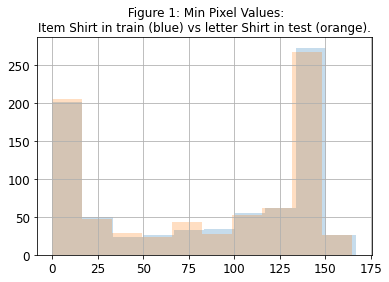

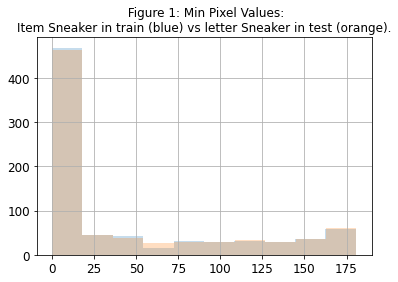

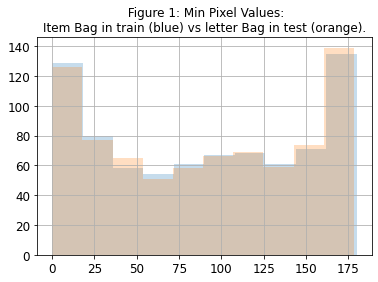

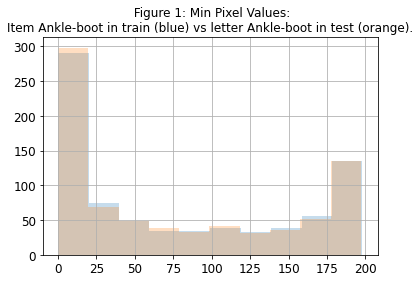

In [33]:
for i in (0,1,2,3,4,5,6,7,8,9):
    #print(' Figure 1: Min Pixel Values:\n', letters[i], 'in train (blue) vs', letters[i], 'in test (orange).')
    data_train.groupby('label').mean().T[i].hist(alpha=0.25)
    data_test.groupby('label').mean().T[i].hist(alpha=0.25)
    title = ' Figure 1: Min Pixel Values:\n' + 'Item ' + str(labels_values[i]) + ' in train (blue) vs letter ' + str(labels_values[i]) + ' in test (orange).'
    plt.title(title)
    plt.show()

In [35]:
print('Table: Mean correlations amongst images of items in test set')
pd.set_option('display.max_columns', None)  
(data_test.groupby('label_str').mean().T.corr()*100).astype(int)

Table: Mean correlations amongst images of items in test set


label_str,Ankle-boot,Bag,Coat,Dress,Pullover,Sandal,Shirt,Sneaker,T-shirt/top,Trouser
label_str,,,,,,,,,,
Ankle-boot,100,69,42,26,41,85,38,68,25,15
Bag,69,100,69,42,66,74,66,67,43,26
Coat,42,69,100,73,95,39,96,34,76,63
Dress,26,42,73,100,64,16,79,20,85,88
Pullover,41,66,95,64,100,38,93,32,73,55
Sandal,85,74,39,16,38,100,33,87,14,6
Shirt,38,66,96,79,93,33,100,29,87,66
Sneaker,68,67,34,20,32,87,29,100,14,13
T-shirt/top,25,43,76,85,73,14,87,14,100,72


In [36]:
print('Table: Mean correlations diff from train to test set')
(data_train.groupby('label_str').mean().T.corr()*100).astype(int) - (data_test.groupby('label_str').mean().T.corr()*100).astype(int)

Table: Mean correlations diff from train to test set


label_str,Ankle-boot,Bag,Coat,Dress,Pullover,Sandal,Shirt,Sneaker,T-shirt/top,Trouser
label_str,,,,,,,,,,
Ankle-boot,0,-1,0,1,0,0,1,-2,0,1
Bag,-1,0,0,1,-1,1,0,0,-1,0
Coat,0,0,0,1,0,0,0,0,-1,1
Dress,1,1,1,0,1,1,-1,0,0,-1
Pullover,0,-1,0,1,0,0,1,-1,-1,1
Sandal,0,1,0,1,0,0,1,0,-1,1
Shirt,1,0,0,-1,1,1,0,0,-1,-1
Sneaker,-2,0,0,0,-1,0,0,0,-2,0
T-shirt/top,0,-1,-1,0,-1,-1,-1,-2,0,1


In [37]:
data_train.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9')]

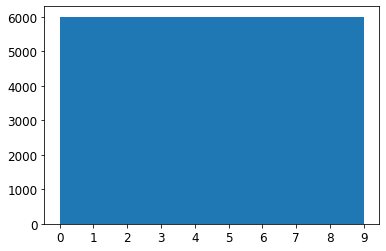

In [38]:
fig, ax = plt.subplots()
ax.hist(data_train.label_str, bins=10)
ax.set_xticklabels(labels)

## Make sets

In [39]:
data_train = pd.read_csv(path_train)
data_test = pd.read_csv(path_test)

#### X nd y into numpy arrays

In [40]:
X_train_2d = np.array(data_train.iloc[:, 1:])
X_test_2d = np.array(data_test.iloc[:, 1:])

y_train = np.array(data_train.iloc[:, 0])
y_test = np.array(data_test.iloc[:, 0])

X_train_2d.shape, X_test_2d.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

#### Shuffle train and test sets

In [41]:
shuffle_index = np.random.permutation(len(X_train_2d))
X_train_2d, y_train = X_train_2d[shuffle_index], y_train[shuffle_index]

X_train_2d.shape, X_test_2d.shape

((60000, 784), (10000, 784))

#### Type, reshape, normalize and make validation sets

In [42]:
X_train_2d, X_valid_2d = X_train_2d[5000:], X_train_2d[:5000]
y_train, y_valid = y_train[5000:],  y_train[:5000]

X_train_2d.shape, y_train.shape, X_valid_2d.shape, y_valid.shape

((55000, 784), (55000,), (5000, 784), (5000,))

#### Make 3d sets for DNN

In [43]:
X_train_3d = X_train_2d.astype(np.float32).reshape(len(X_train_2d),28,28)/255.0
X_valid_3d = X_valid_2d.astype(np.float32).reshape(len(X_valid_2d),28,28)/255.0
X_test_3d = X_test_2d.astype(np.float32).reshape(len(X_test_2d),28,28)/255.0

X_train_3d.shape, X_valid_3d.shape, X_test_3d.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

#### Make 4d sets for CNN

In [44]:
X_train_4d = X_train_2d.astype(np.float32).reshape(len(X_train_2d),28,28,1)/255.0
X_valid_4d = X_valid_2d.astype(np.float32).reshape(len(X_valid_2d),28,28,1)/255.0
X_test_4d = X_test_2d.astype(np.float32).reshape(len(X_test_2d),28,28,1)/255.0

X_train_4d.shape, X_valid_4d.shape, X_test_4d.shape

((55000, 28, 28, 1), (5000, 28, 28, 1), (10000, 28, 28, 1))

### Validation set

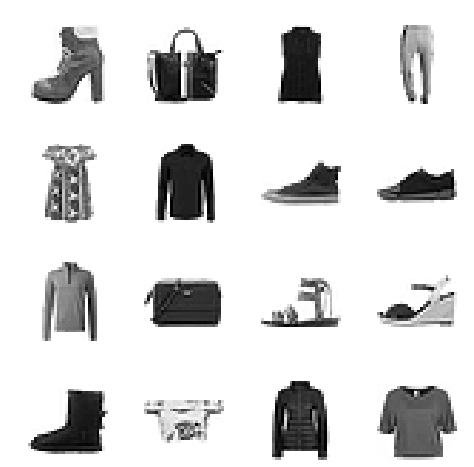

In [45]:
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_3d[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title((y_train[index],labels[y_train[index]]), fontsize=15, color='white')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#### Random Forest with 2d set

In [48]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=seed)
rnd_clf.fit(X_train_2d, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### See it

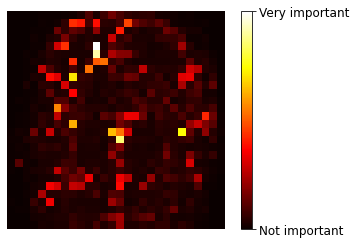

In [49]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

### Hyperparameters

In [50]:
n_inputs = X_train_3d.shape[1]
n_hidden = 256
n_outputs = 10
n_epochs = 10
batch_size = 128

optimizer = 'adam'
activation_h = 'relu'
activation_o = 'softmax'
dropout = 0.25

import datetime
# Unused
learning_rate = 0.01
#save_path = saver.save(sess, './my_model_final.ckpt')
checkpoint_path = "/tmp/my_deep_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_deep_mnist_model"
best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

### DNN

In [51]:
config_name = 'FC'
dataset = 'FMNIST'
model_note = ''
pixels = 28
input_depth = 1
if input_depth == 1:
    color_depth = 'grayscale'
elif input_depth ==3:
    color_depth = 'RGB'
model_filename_h5 = dataset + '_' + str(input_depth) + 'd_' + str(pixels) + str(pixels) + '_' + stamp() + '_' + config_name + '.h5'
model_filename_json = dataset + '_' + str(input_depth) + 'd_' + str(pixels) + str(pixels) + '_' + stamp() + '_' + config_name +'.json'
model_filename_h5, model_filename_json

('FMNIST_1d_2828_2020602719_FC.h5', 'FMNIST_1d_2828_2020602719_FC.json')

In [52]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_inputs, n_inputs)),
    tf.keras.layers.Dense(n_hidden, activation=activation_h),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(n_outputs, activation=activation_o)
  ])

model_FC = create_model()

model_FC.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

print("Figure: Fully connected model to \nClassify the 28x28 Fashion MNIST dataset:\n")

model_FC.summary()

Figure: Fully connected model to 
Classify the 28x28 Fashion MNIST dataset:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [53]:
start_time = time.time()
history = model_FC.fit(x=X_train_3d, y=y_train, 
            batch_size=batch_size,
            epochs=n_epochs, 
            validation_data=(X_valid_3d, y_valid))
elapsed = time.time()-start_time
print(f'\nFully connected training took {elapsed} seconds')
saveModel(model_FC, model_filename_json)

Epoch 1/10
430/430 [==============================] - 1s 2ms/step - loss: 0.5791 - accuracy: 0.7971 - val_loss: 0.4217 - val_accuracy: 0.8470
Epoch 2/10
430/430 [==============================] - 1s 2ms/step - loss: 0.4178 - accuracy: 0.8502 - val_loss: 0.3705 - val_accuracy: 0.8660
Epoch 3/10
430/430 [==============================] - 1s 2ms/step - loss: 0.3764 - accuracy: 0.8670 - val_loss: 0.3533 - val_accuracy: 0.8710
Epoch 4/10
430/430 [==============================] - 1s 2ms/step - loss: 0.3510 - accuracy: 0.8732 - val_loss: 0.3395 - val_accuracy: 0.8718
Epoch 5/10
430/430 [==============================] - 1s 2ms/step - loss: 0.3338 - accuracy: 0.8797 - val_loss: 0.3275 - val_accuracy: 0.8754
Epoch 6/10
430/430 [==============================] - 1s 2ms/step - loss: 0.3200 - accuracy: 0.8835 - val_loss: 0.3421 - val_accuracy: 0.8744
Epoch 7/10
430/430 [==============================] - 1s 2ms/step - loss: 0.3111 - accuracy: 0.8857 - val_loss: 0.3158 - val_accuracy: 0.8786
Epoch 

In [54]:
model_dict = loadModel(model_filename_json)
model_layers = [model_dict['config']['config']['layers'][i]['class_name'] for i in range(len(model_dict['config']['config']['layers']))]
''.join(model_layers)

model_dict['params']

{'epochs': '10', 'steps': '430', 'verbose': '1'}

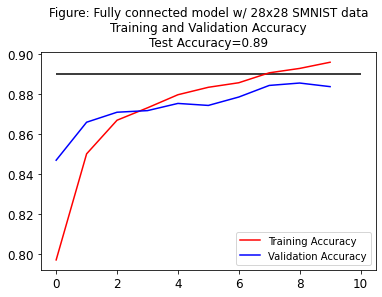

<Figure size 432x288 with 0 Axes>

In [56]:
acc = model_dict['history']['accuracy']
val_acc = model_dict['history']['val_accuracy']
loss = model_dict['history']['loss']
val_loss = model_dict['history']['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
test_accuracy = round(model_FC.evaluate(X_test_4d, y_test, verbose=0)[1],2)
plt.title(f'Figure: Fully connected model w/ 28x28 SMNIST data\nTraining and Validation Accuracy\nTest Accuracy={test_accuracy}')
plt.legend(loc=4)
plt.hlines(test_accuracy, 0, n_epochs, label='test')
plt.figure()
plt.show()


#### CNN

In [57]:
config_name = 'CNN'
dataset = 'FMNIST'
model_note = ''
pixels = 28
input_depth = 1
if input_depth == 1:
    color_depth = 'grayscale'
elif input_depth ==3:
    color_depth = 'RGB'
model_filename_h5 = dataset + '_' + str(input_depth) + 'd_' + str(pixels) + str(pixels) + '_' + stamp() + '_' + config_name + '.h5'
model_filename_json = dataset + '_' + str(input_depth) + 'd_' + str(pixels) + str(pixels) + '_' + stamp() + '_' + config_name +'.json'
model_filename_h5, model_filename_json

('FMNIST_1d_2828_2020602719_CNN.h5', 'FMNIST_1d_2828_2020602719_CNN.json')

In [58]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def create_model():
  return tf.keras.Sequential([
    tf.keras.layers.Conv2D(n_hidden/4, (3,3), activation=activation_h, 
                                   input_shape=(n_inputs,n_inputs,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(n_hidden/4, (3,3), activation=activation_h),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(n_hidden/2, (3,3), activation=activation_h),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=activation_h),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(n_outputs, activation=activation_o)
])

model_CNN = create_model()

model_CNN.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

print("Figure: Fully connected model to \nClassify the 28x28 Fashion MNIST dataset:\n")

model_CNN.summary()


Figure: Fully connected model to 
Classify the 28x28 Fashion MNIST dataset:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 128)         0         
_____________________________________________

In [59]:
start_time=time.time()

history = model_CNN.fit(X_train_4d, 
          y_train, 
          batch_size=batch_size, 
          epochs=n_epochs, 
          verbose=1,
          validation_data=(X_valid_4d, y_valid))

elapsed = time.time()-start_time

print(f'\nTraining took {elapsed} seconds')

saveModel(model_CNN, model_filename_json)

Epoch 1/10
430/430 [==============================] - 2s 5ms/step - loss: 0.6856 - accuracy: 0.7483 - val_loss: 0.4151 - val_accuracy: 0.8480
Epoch 2/10
430/430 [==============================] - 2s 4ms/step - loss: 0.4290 - accuracy: 0.8458 - val_loss: 0.3470 - val_accuracy: 0.8722
Epoch 3/10
430/430 [==============================] - 2s 4ms/step - loss: 0.3619 - accuracy: 0.8697 - val_loss: 0.2900 - val_accuracy: 0.8904
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.3256 - accuracy: 0.8839 - val_loss: 0.2751 - val_accuracy: 0.8996
Epoch 5/10
430/430 [==============================] - 2s 4ms/step - loss: 0.3001 - accuracy: 0.8924 - val_loss: 0.2603 - val_accuracy: 0.9008
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.2793 - accuracy: 0.8992 - val_loss: 0.2673 - val_accuracy: 0.8986
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.2622 - accuracy: 0.9040 - val_loss: 0.2438 - val_accuracy: 0.9058
Epoch 

In [60]:
model_dict = loadModel(model_filename_json)
model_layers = [model_dict['config']['config']['layers'][i]['class_name'] for i in range(len(model_dict['config']['config']['layers']))]
''.join(model_layers)

model_dict['params']

{'epochs': '10', 'steps': '430', 'verbose': '1'}

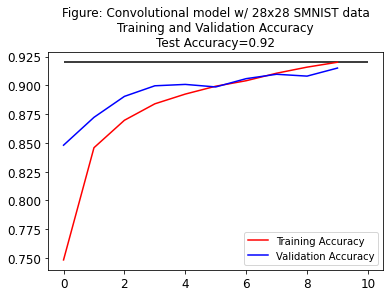

<Figure size 432x288 with 0 Axes>

In [61]:
acc = model_dict['history']['accuracy']
val_acc = model_dict['history']['val_accuracy']
loss = model_dict['history']['loss']
val_loss = model_dict['history']['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
test_accuracy = round(model_CNN.evaluate(X_test_4d, y_test, verbose=0)[1],2)
plt.title(f'Figure: Convolutional model w/ 28x28 SMNIST data\nTraining and Validation Accuracy\nTest Accuracy={test_accuracy}')
plt.legend(loc=4)
plt.hlines(test_accuracy, 0, n_epochs, label='test')
plt.figure()
plt.show()


In [62]:
# Kinghorn code had issues with TensorBoard, so we modified it.
# https://stackoverflow.com/questions/56851298/tensorboard-tensorflow-python-framework-errors-impl-notfounderror
import datetime
logdir = os.path.join(
    os.getcwd(),
    "logs",
    "mnist-cnn-fit",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
print('Current working directory: ' + os.getcwd())
print('TensorBoard log directory for this analysis: ' + logdir )

os.makedirs(logdir)

tensorboard_callback =  tf.keras.callbacks.TensorBoard(logdir)

import time
# Recall the locations of the working directory and TensorBoard logs
print('Current working directory: ' + os.getcwd())
print('TensorBoard log directory for this analysis: ' + logdir )


Current working directory: /content
TensorBoard log directory for this analysis: /content/logs/mnist-cnn-fit/20200627-051017
Current working directory: /content
TensorBoard log directory for this analysis: /content/logs/mnist-cnn-fit/20200627-051017


In [63]:
confusion_FC = confusion_matrix(y_test, model_FC.predict_classes(X_test_4d))
confusion_CNN = confusion_matrix(y_test, model_CNN.predict_classes(X_test_4d))
print("Confusion matrix for fully connected\n")
confusion_FC

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion matrix for fully connected



array([[817,   0,  10,  48,   1,   0, 118,   0,   6,   0],
       [  1, 980,   2,  13,   0,   1,   3,   0,   0,   0],
       [ 10,   0, 812,  18, 100,   0,  58,   0,   2,   0],
       [ 13,  10,   6, 944,  14,   1,  10,   0,   2,   0],
       [  0,   1,  57,  49, 857,   0,  34,   0,   2,   0],
       [  0,   0,   0,   0,   0, 953,   0,  35,   3,   9],
       [125,   2,  83,  46,  83,   0, 652,   0,   9,   0],
       [  0,   0,   0,   0,   0,  17,   0, 928,   0,  55],
       [  2,   0,   8,   1,   5,   2,   6,   1, 975,   0],
       [  0,   0,   0,   0,   0,   5,   0,  27,   0, 968]])

In [64]:
print("Confusion matrix for convolutional model\n")
confusion_CNN

Confusion matrix for convolutional model



array([[856,   6,  13,  23,   0,   2,  98,   0,   2,   0],
       [  0, 992,   1,   5,   0,   1,   1,   0,   0,   0],
       [ 11,   0, 858,  11,  47,   1,  71,   0,   1,   0],
       [  8,   9,   9, 935,  16,   0,  23,   0,   0,   0],
       [  0,   2,  29,  26, 860,   0,  83,   0,   0,   0],
       [  1,   0,   0,   0,   0, 980,   0,  15,   0,   4],
       [100,   5,  42,  23,  32,   0, 796,   0,   2,   0],
       [  0,   0,   0,   0,   0,   6,   0, 966,   0,  28],
       [  2,   1,   3,   0,   1,   1,   9,   2, 981,   0],
       [  0,   0,   0,   0,   0,   2,   0,  32,   0, 966]])

In [65]:
((model_CNN.predict_classes(X_test_4d) == 6) & (y_test == 0)).astype(int).sum()

98

In [66]:
model = model_CNN

In [67]:
layer_outputs = [layer.output for layer in model.layers[:5]]
activation_model = tf.keras.models.Model(inputs=model.input,outputs=layer_outputs)
model.input, layer_outputs, activation_model

(<tf.Tensor 'conv2d_input:0' shape=(None, 28, 28, 1) dtype=float32>,
 [<tf.Tensor 'conv2d/Identity:0' shape=(None, 26, 26, 64) dtype=float32>,
  <tf.Tensor 'max_pooling2d/Identity:0' shape=(None, 13, 13, 64) dtype=float32>,
  <tf.Tensor 'conv2d_1/Identity:0' shape=(None, 11, 11, 64) dtype=float32>,
  <tf.Tensor 'max_pooling2d_1/Identity:0' shape=(None, 5, 5, 64) dtype=float32>,
  <tf.Tensor 'conv2d_2/Identity:0' shape=(None, 3, 3, 128) dtype=float32>],
 <tensorflow.python.keras.engine.training.Model at 0x7fb8b81a0d68>)

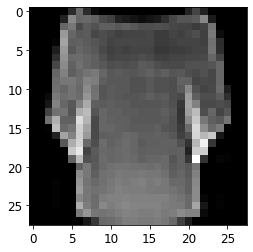

(None, (28, 28, 1), (1, 28, 28, 1), (28, 28))

In [68]:
img_tensor = np.expand_dims(X_test_4d[5], axis=0)
plt.imshow(X_test_4d[5][:,:,-1], cmap="gray", interpolation="nearest")
plt.show(), X_test_4d[5].shape, img_tensor.shape, X_test_4d[0][:,:,-1].shape

#### List of layer activations

In [69]:
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
second_layer_activation = activations[1]
third_layer_activation = activations[3]
first_layer_activation.shape, second_layer_activation.shape, third_layer_activation.shape

((1, 26, 26, 64), (1, 13, 13, 64), (1, 5, 5, 64))

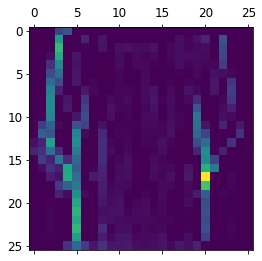

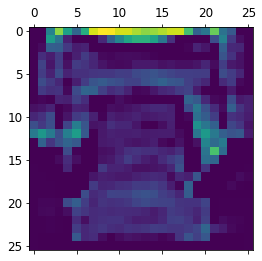

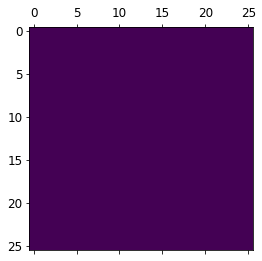

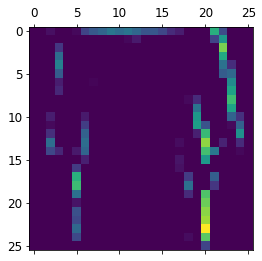

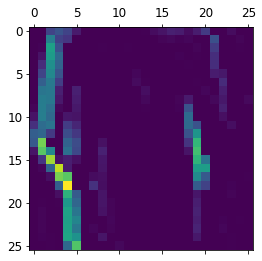

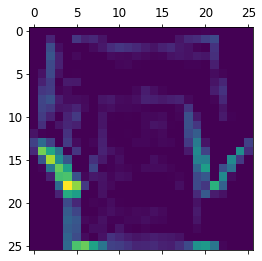

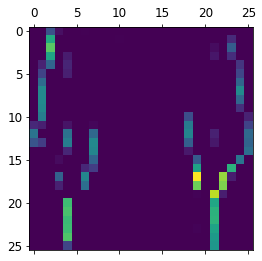

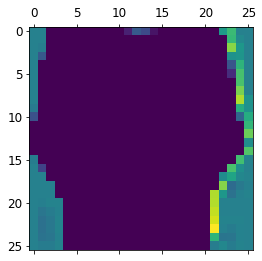

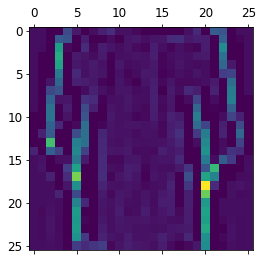

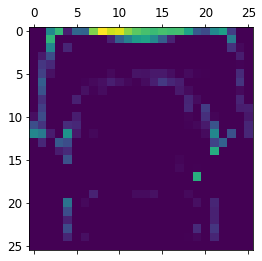

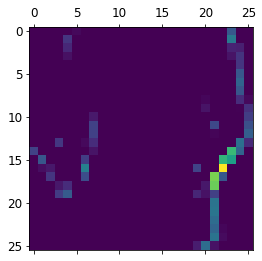

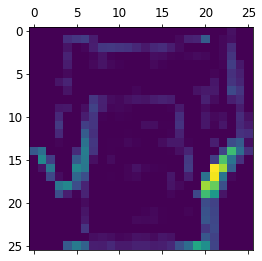

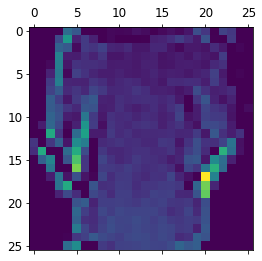

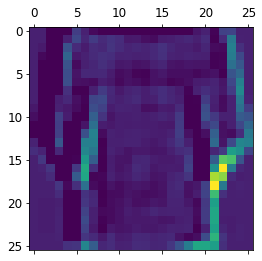

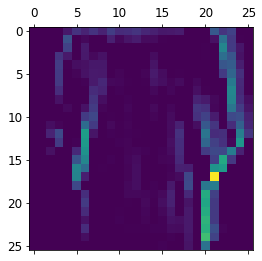

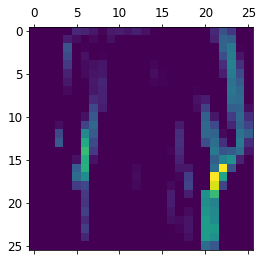

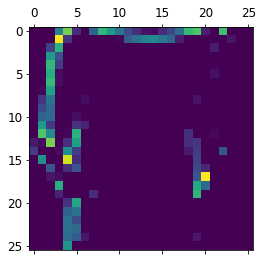

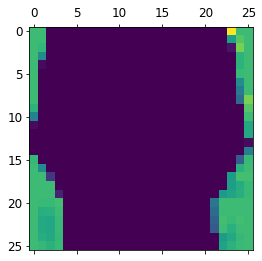

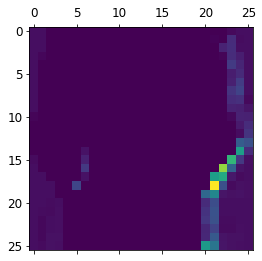

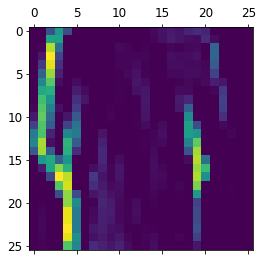

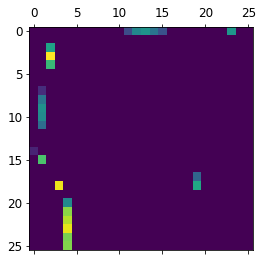

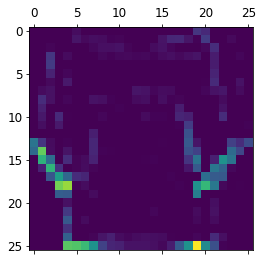

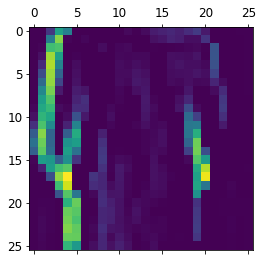

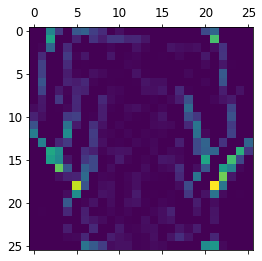

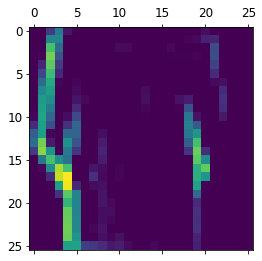

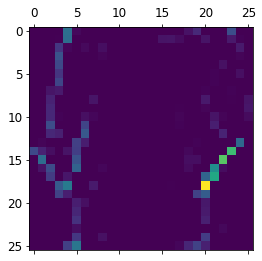

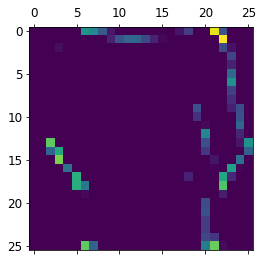

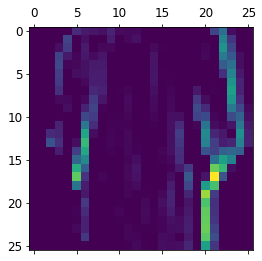

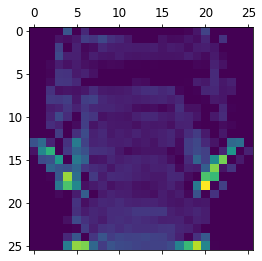

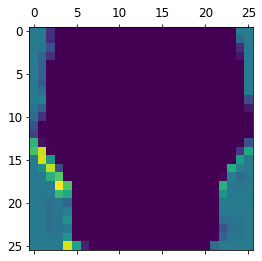

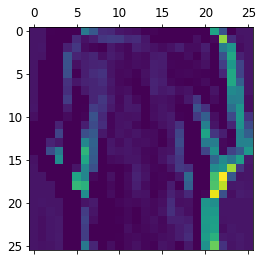

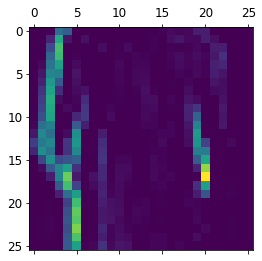

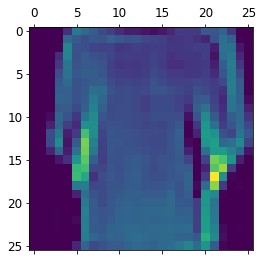

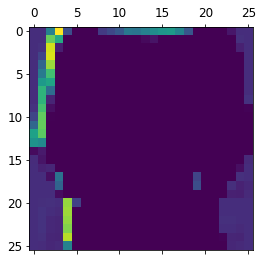

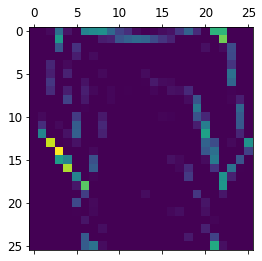

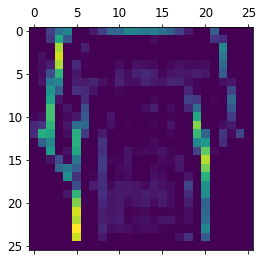

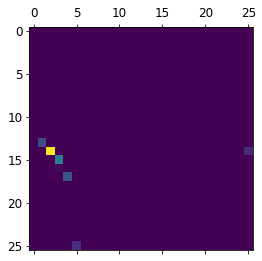

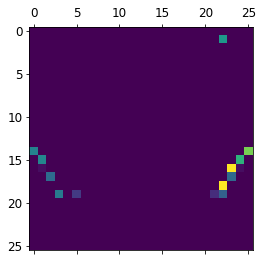

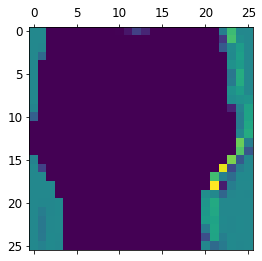

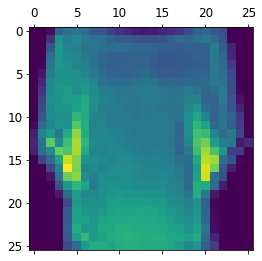

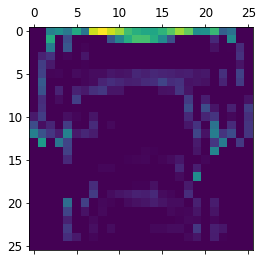

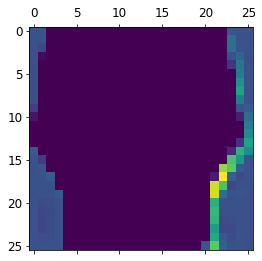

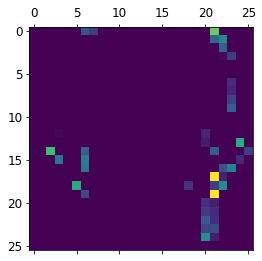

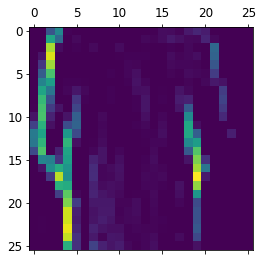

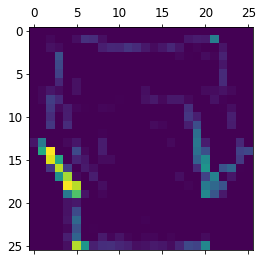

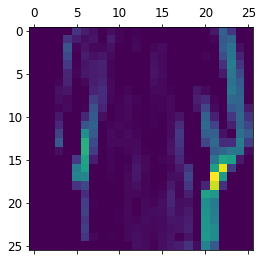

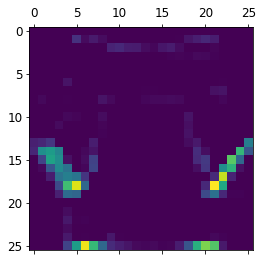

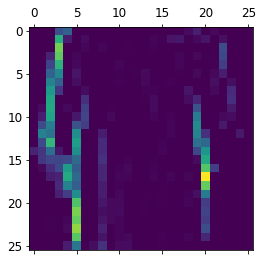

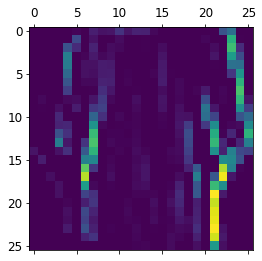

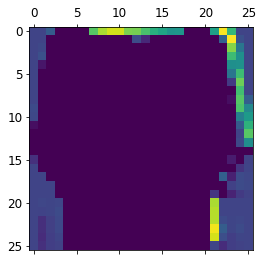

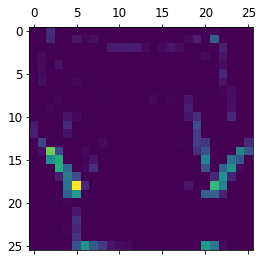

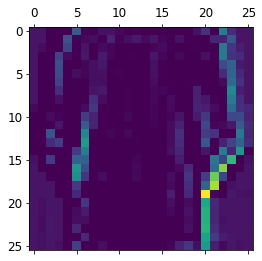

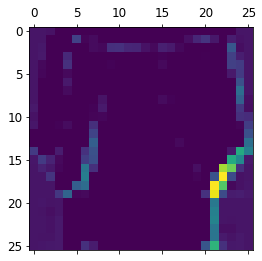

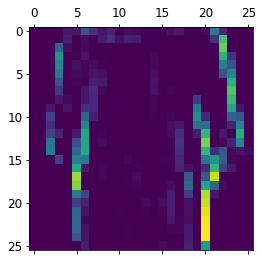

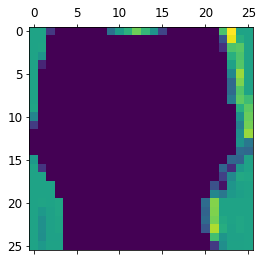

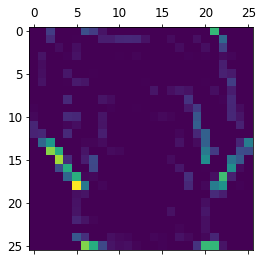

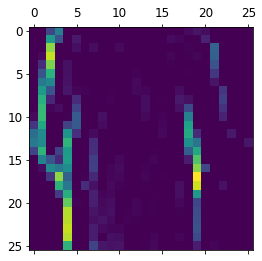

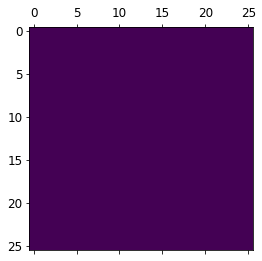

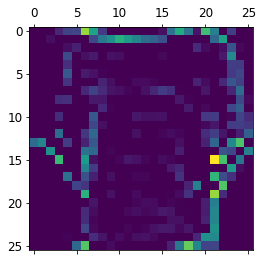

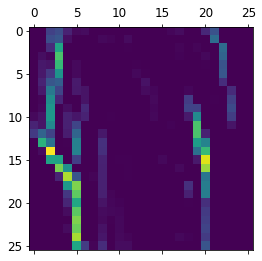

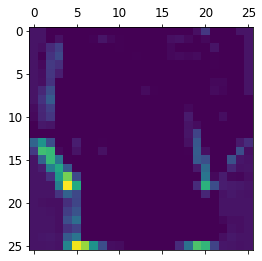

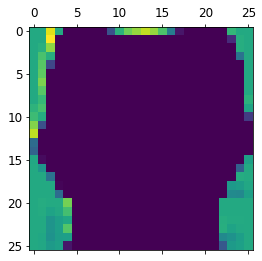

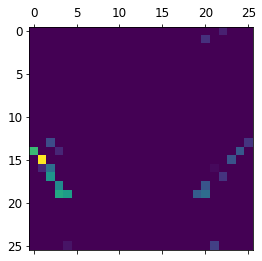

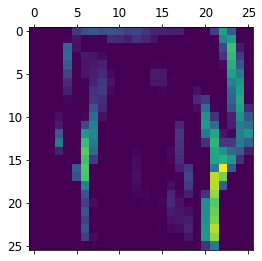

In [ ]:
cells = first_layer_activation[0][0][0].shape[0]

for cell in range(cells):
    plt.matshow(first_layer_activation[0, :, :, cell], cmap='viridis')
    plt.show()

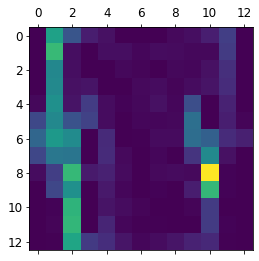

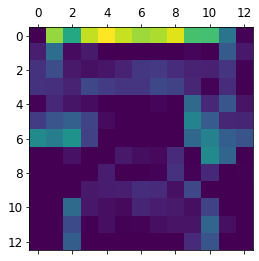

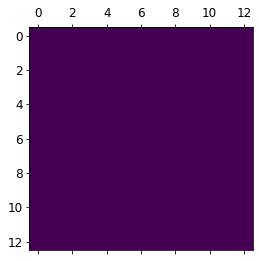

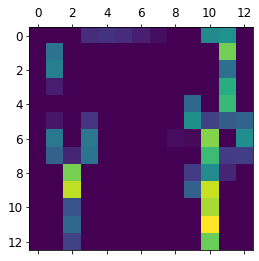

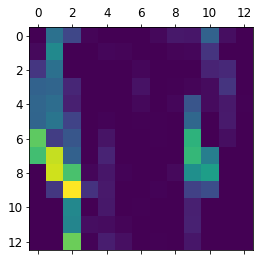

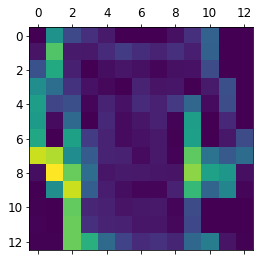

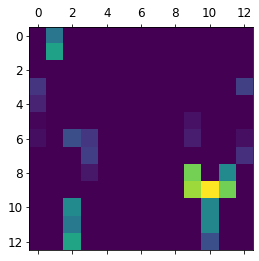

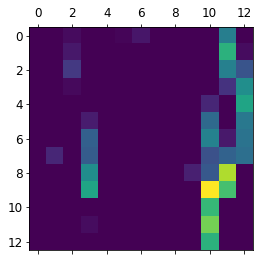

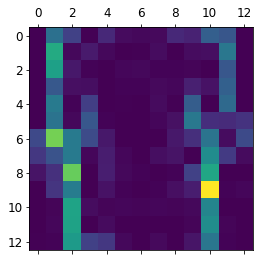

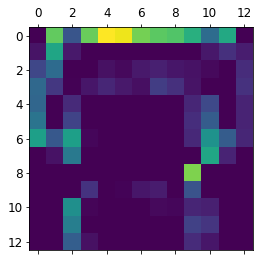

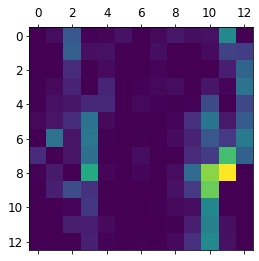

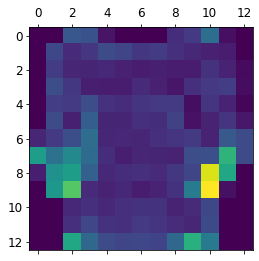

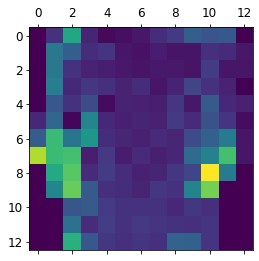

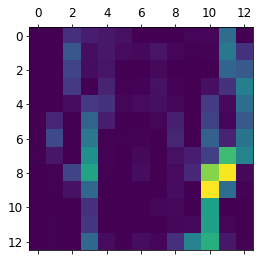

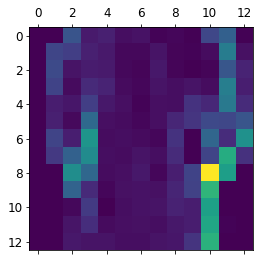

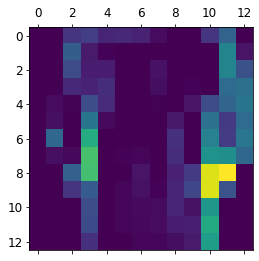

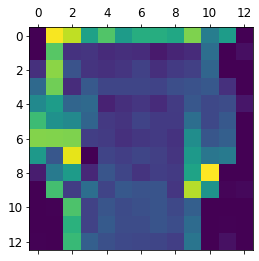

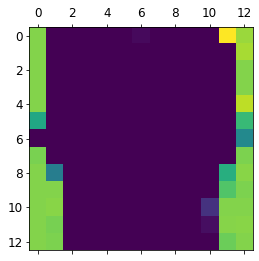

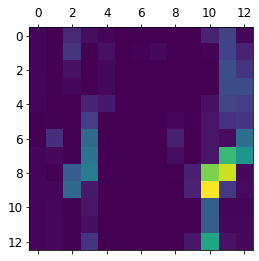

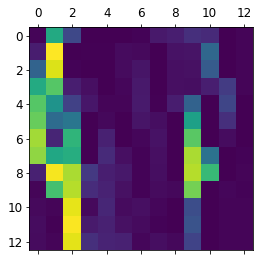

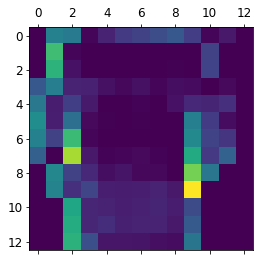

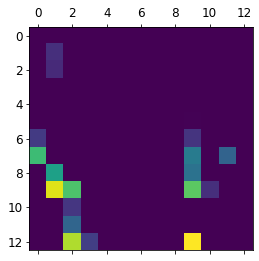

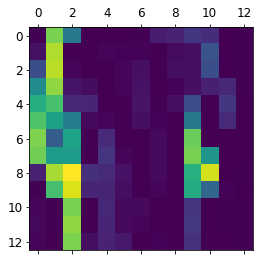

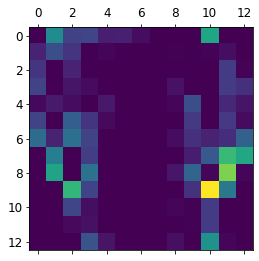

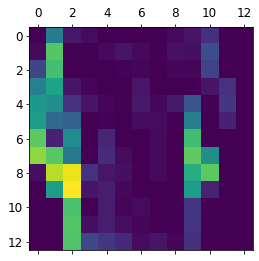

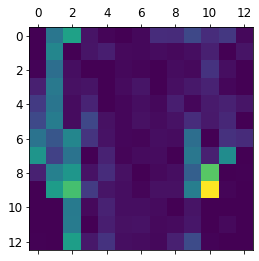

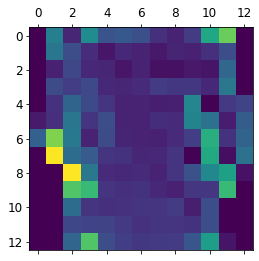

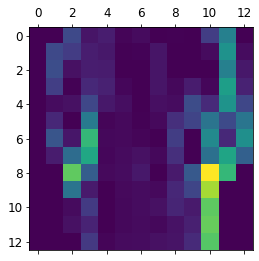

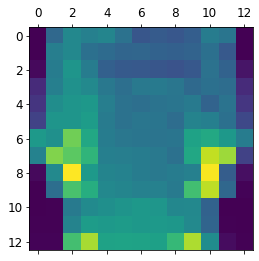

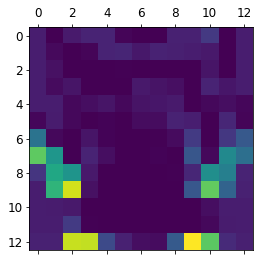

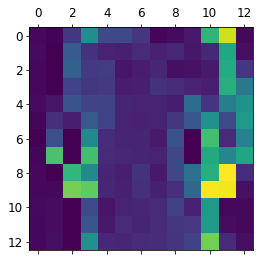

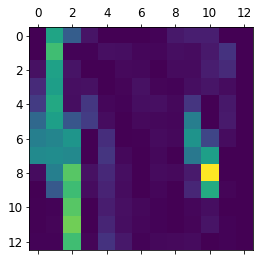

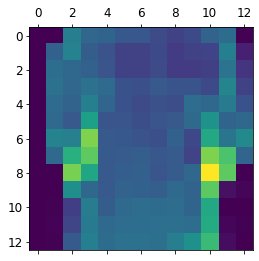

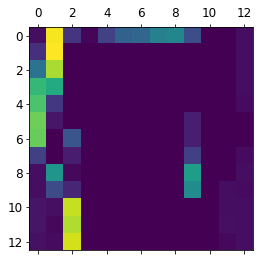

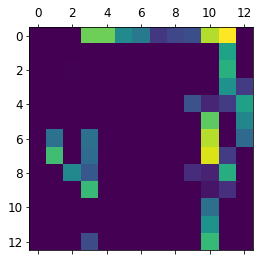

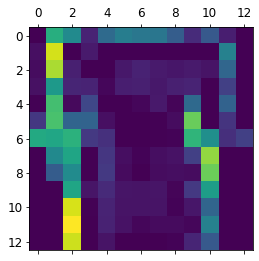

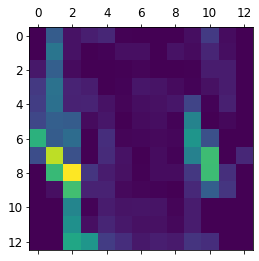

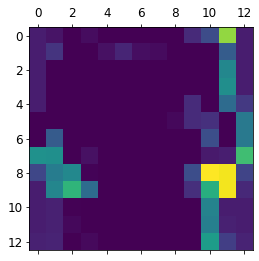

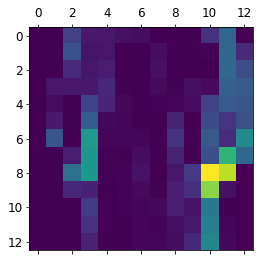

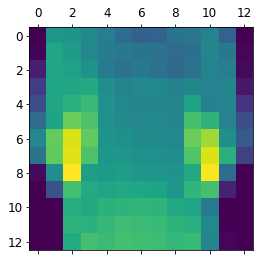

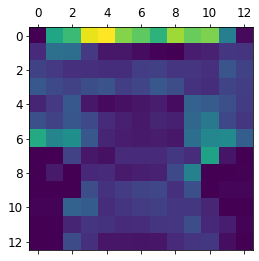

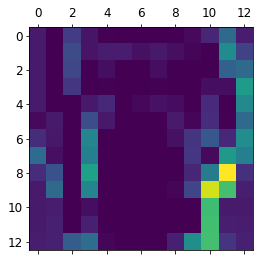

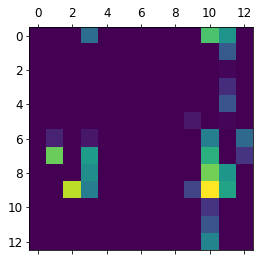

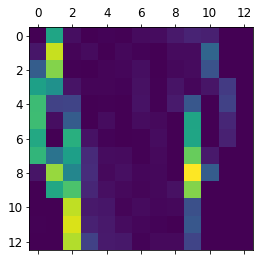

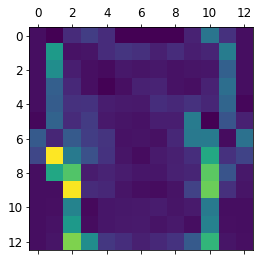

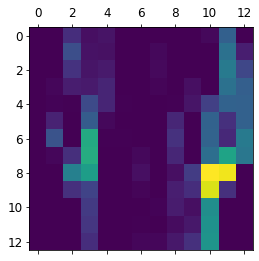

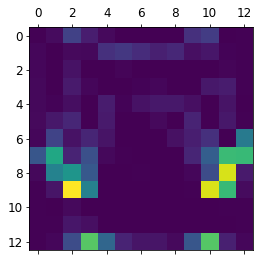

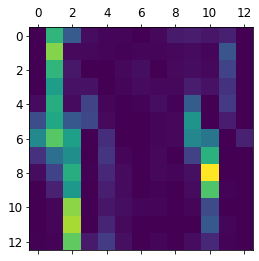

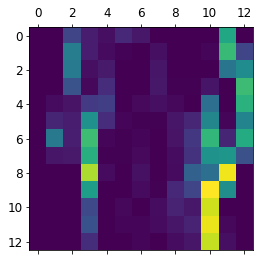

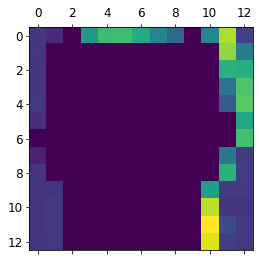

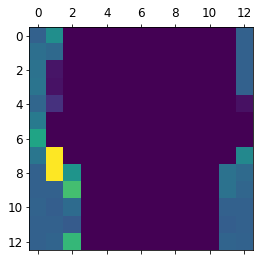

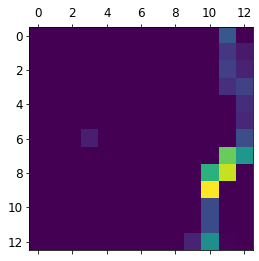

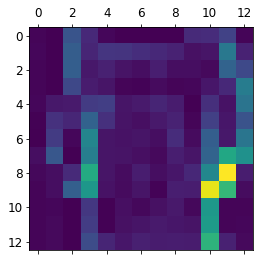

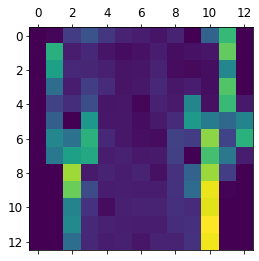

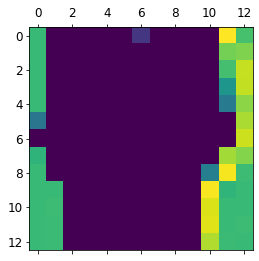

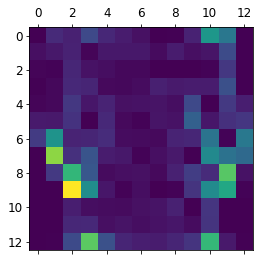

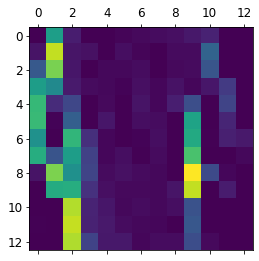

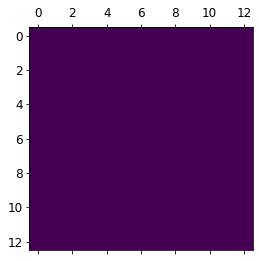

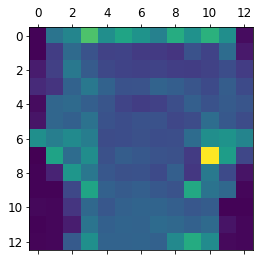

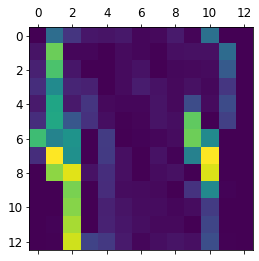

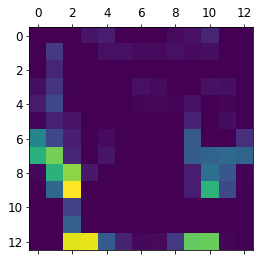

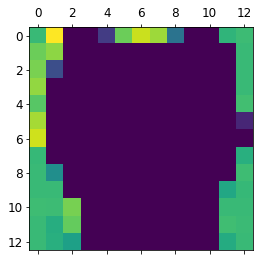

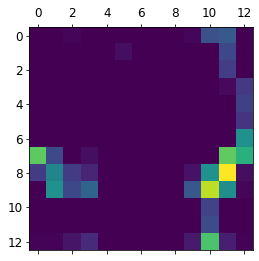

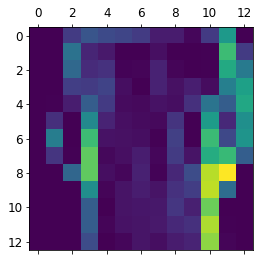

In [70]:
cells = second_layer_activation[0][0][0].shape[0]

for cell in range(cells):
    plt.matshow(second_layer_activation[0, :, :, cell], cmap='viridis')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


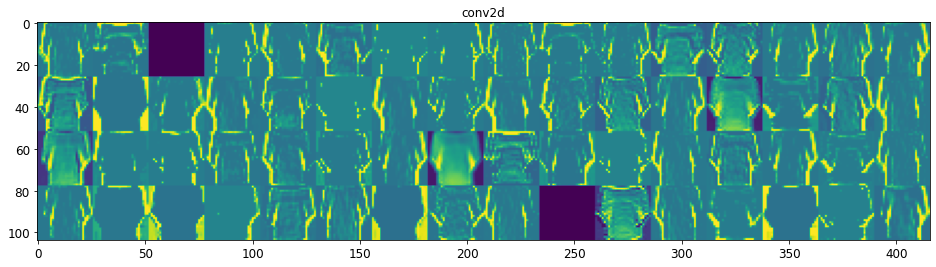

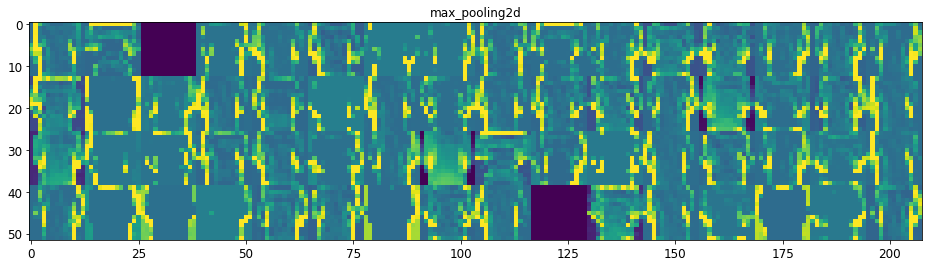

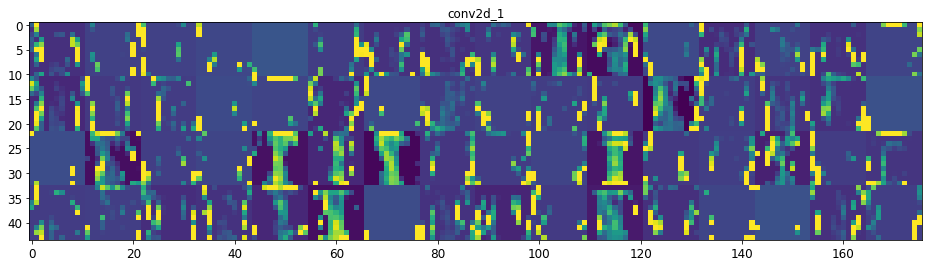

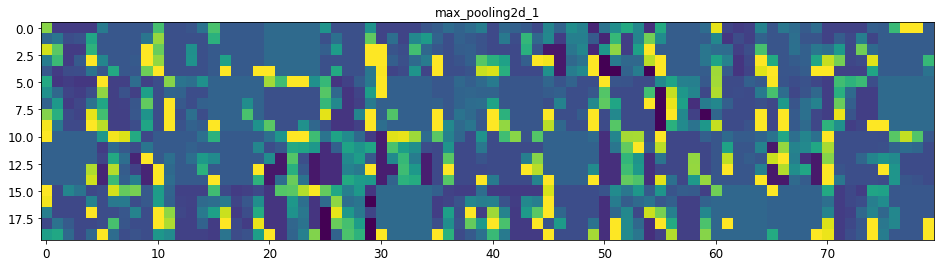

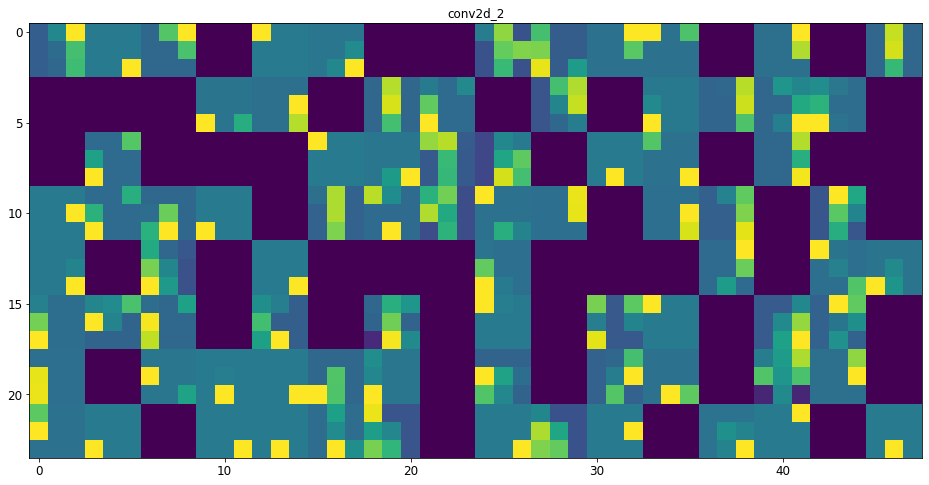

In [71]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64 # contrast
            channel_image += 128 # brightness
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [72]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 64
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [73]:
def generate_pattern(model, layer_name, filter_index, size=28, color_depth=1):

    epochs = 100
    step_size = 1.

    # Create a connection between the input and the target layer
    submodel = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).output])

    # Initiate random noise
    # input_img_data = np.random.random((1, size, size, color_depth)) * 20 + 128.

    input_img_data = np.random.random((1, size, size, color_depth))
    input_img_data = (input_img_data - 0.5) * 20 + 128.

    # Cast random noise from np.float64 to tf.float32 Variable
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    # Iterate gradient ascents
    for _ in range(epochs):
        with tf.GradientTape() as tape:
            outputs = submodel(input_img_data)
            loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
        grads = tape.gradient(loss_value, input_img_data)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_img_data.assign_add(normalized_grads * step_size)
    img = input_img_data
    img = img[0]
    img = np.array(img)
    return deprocess_image(img)
    #plt.imshow(img[:,:,-1], cmap="gray", interpolation="nearest")
    #plt.show()

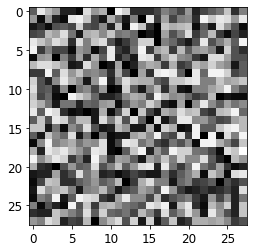

In [74]:
size = 28
filter_index = 6
model = model
layers = [layer for layer in model.layers if 'conv' in layer.name]
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

layer_index = 1
layer = layers[layer_index]
layer_name = layer.name
color_depth = 1

img = generate_pattern(model, layer_name, 1, 28, 1)
plt.imshow(img[:,:,-1], cmap="gray", interpolation="nearest")
plt.show()

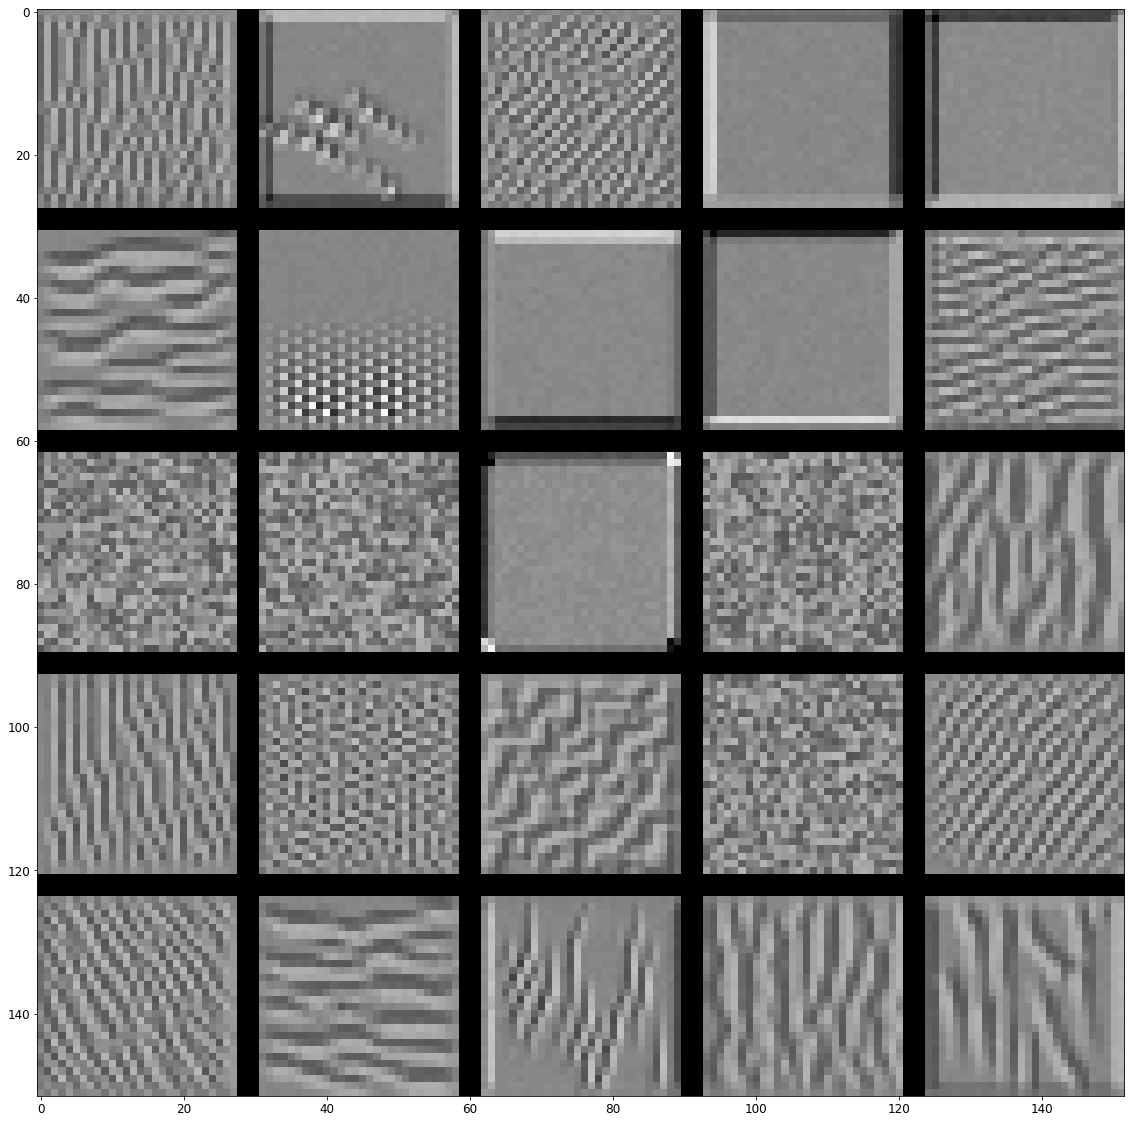

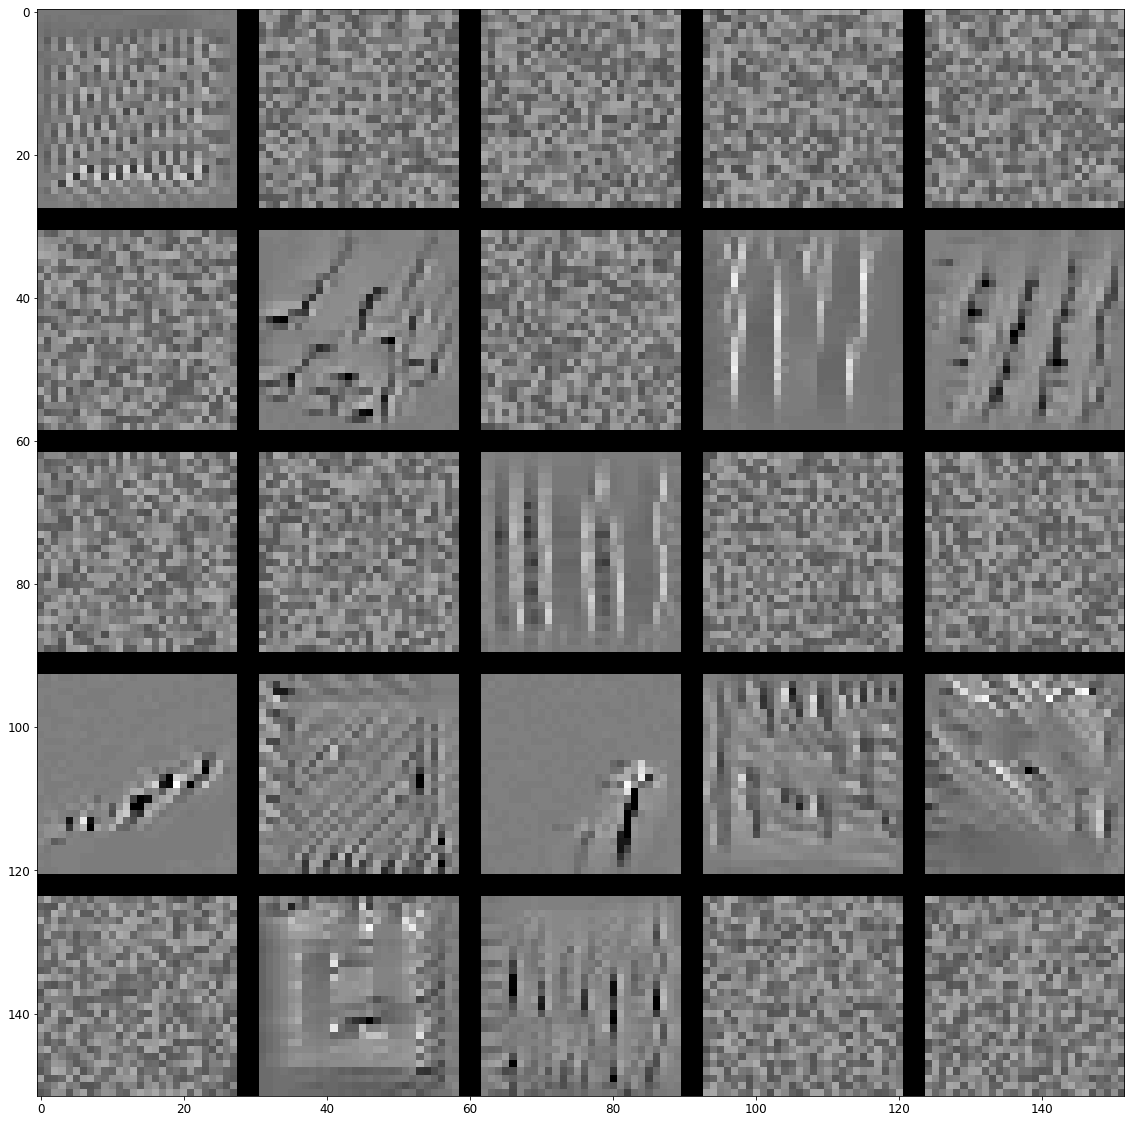

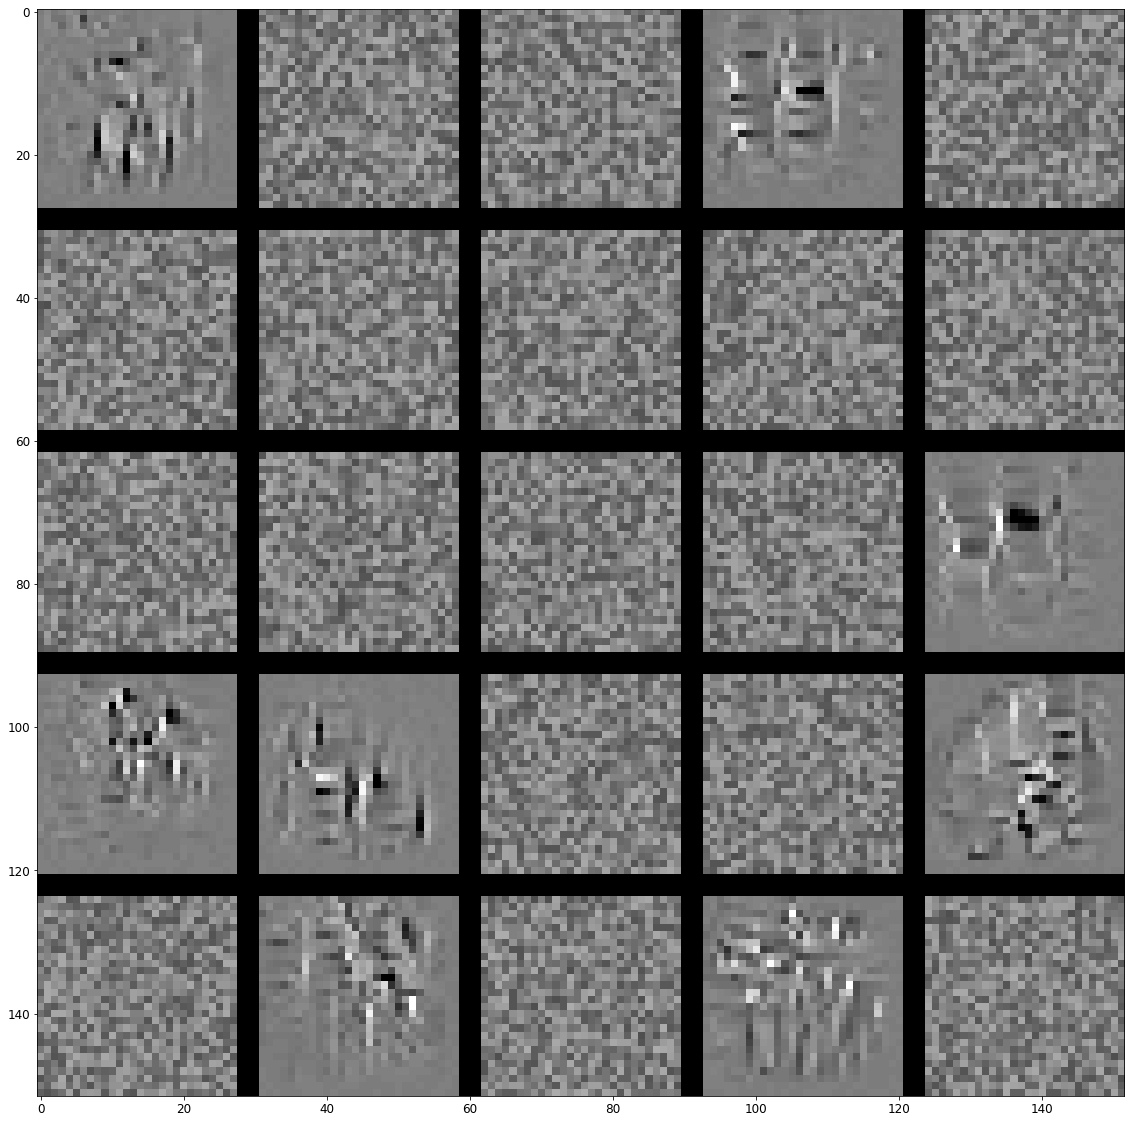

In [75]:
layers_ = [layer for layer in model.layers if 'conv' in layer.name]
size = 28
color_depth = 1
margin = 3
model = model


for layer_ in layers_:
    layer_name = layer_.name
    filter_count = layer_.filters
    width = 5
    length = filter_count // width
    # This a empty (black) image where we will store our results.
    results = np.zeros((5 * size + 4 * margin, 5 * size + 4 * margin, 1))

    for i in range(5):  # iterate over the rows of our results grid
        for j in range(5):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(model, layer_name, i + (j * 5), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results[:,:,-1], cmap="gray", interpolation="nearest")
    plt.show()

In [77]:
def gradient_heatmap(idx, X_4d_1c, y_1d, model):
    layers = [layer for layer in model.layers if 'conv' in layer.name]
    print(X_4d_1c.shape, X_4d_1c[idx].shape)        
    x = X_4d_1c[idx]                        # 10000,28, 28, 1--> 28,28,1
    print(x[:,:,-1].shape)                  # 28,28,1 --> 28,28
    plt.matshow(x[:,:,-1])
    plt.show()
    print(x.shape, np.expand_dims(x, axis=0).shape)        
    x = np.expand_dims(x, axis=0)           # 28,28,1 --> 1,28,28,1
    with tf.GradientTape() as tape:
        last_conv_layer = layers[-1]
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap[0]

    plt.matshow(heatmap)
    plt.show()
    imageforoverlay = X_4d_1c[idx][:,:,-1]
    import cv2
    heatmap = cv2.resize(heatmap, (imageforoverlay.shape[1], imageforoverlay.shape[0]))
    plt.matshow(heatmap)
    plt.show()
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    plt.matshow(heatmap)
    plt.show()
    imageforoverlay2 = np.zeros_like(heatmap)
    imageforoverlay2[:,:,0] = X_4d_1c[idx][:,:,-1]*255
    imageforoverlay2[:,:,1] = X_4d_1c[idx][:,:,-1]*255
    imageforoverlay2[:,:,2] = X_4d_1c[idx][:,:,-1]*255
    superimposed_img = heatmap *.4 + imageforoverlay2
    # Save the image to disk
    cv2.imwrite('bob.jpeg', superimposed_img)
    plt.matshow(superimposed_img.astype(int))




(10000, 28, 28, 1) (28, 28, 1)
(28, 28)


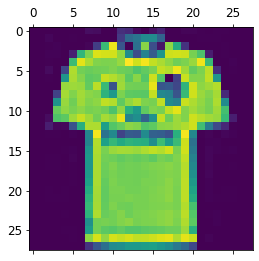

(28, 28, 1) (1, 28, 28, 1)


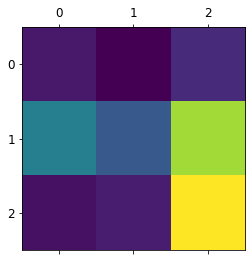

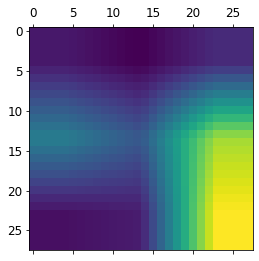

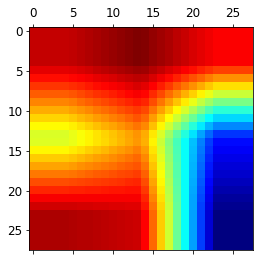

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


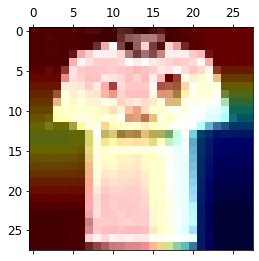

In [ ]:
gradient_heatmap(0,X_test_4d, y_test, model)

(10000, 28, 28, 1) (28, 28, 1)
(28, 28)


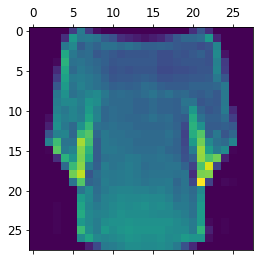

(28, 28, 1) (1, 28, 28, 1)


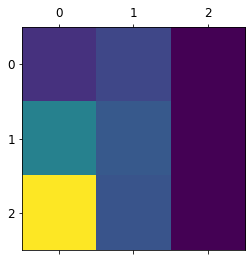

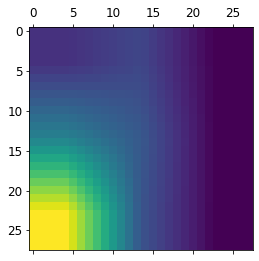

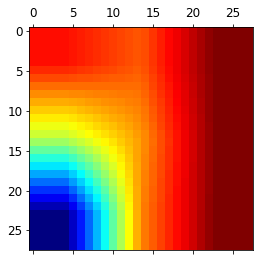

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


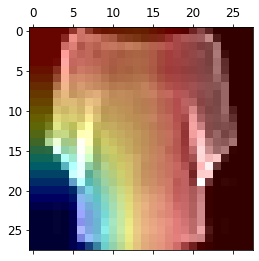

In [ ]:
gradient_heatmap(5,X_test_4d, y_test, model)